In [2]:
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
setup_google_colab.setup_week2_v2()
# change to the week you're working on
# note on week 2: select setup_week2_v2() if you've started the course after August 13, 2018,
# otherwise call setup_week2().


!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip




Redirecting output to ‘wget-log.2’.
**************************************************
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
**************************************************
cifar-10-batches-py.tar.gz
**************************************************
mnist.npz

Redirecting output to ‘wget-log.3’.
Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
def tensorBoard():
  LOG_DIR = 'tensorboard_logs'
  get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
   )
  get_ipython().system_raw('./ngrok http 6006 &')
  !curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

# Intro to TensorFlow

This notebook covers the basics of TF and shows you an animation with gradient descent trajectory.
<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week2/v2/images/gradient_descent.png?raw=1" style="width:50%">

# TensorBoard

**Plase note that if you are running on the Coursera platform, you won't be able to access the tensorboard instance due to the network setup there.**

Run `tensorboard --logdir=./tensorboard_logs --port=7007` in bash.

If you run the notebook locally, you should be able to access TensorBoard on http://127.0.0.1:7007/

In [4]:
import tensorflow as tf
import sys
sys.path.append("../..")
from keras_utils import reset_tf_session
s = reset_tf_session()
print("We're using TF", tf.__version__)

Using TensorFlow backend.


We're using TF 1.10.1


# Warming up
For starters, let's implement a python function that computes the sum of squares of numbers from 0 to N-1.

In [0]:
import numpy as np

def sum_python(N):
    return np.sum(np.arange(N)**2)

In [6]:
%%time
sum_python(10**5)

CPU times: user 3.44 ms, sys: 0 ns, total: 3.44 ms
Wall time: 6.02 ms


333328333350000

# Tensoflow teaser

Doing the very same thing

In [0]:
# An integer parameter
N = tf.placeholder('int64', name="input_to_your_function")

# A recipe on how to produce the same result
result = tf.reduce_sum(tf.range(N)**2)

In [8]:
# just a graph definition
result

<tf.Tensor 'Sum:0' shape=() dtype=int64>

In [9]:
%%time
# actually executing
result.eval({N: 10**5})

CPU times: user 3.72 ms, sys: 1.85 ms, total: 5.57 ms
Wall time: 8.8 ms


333328333350000

In [0]:
# logger for tensorboard
writer = tf.summary.FileWriter("tensorboard_logs", graph=s.graph)

In [11]:
tensorBoard()

http://a2153927.ngrok.io


# How does it work?
1. Define placeholders where you'll send inputs
2. Make a symbolic graph: a recipe for mathematical transformation of those placeholders
3. Compute outputs of your graph with particular values for each placeholder
  * `output.eval({placeholder: value})`
  * `s.run(output, {placeholder: value})`

So far there are two main entities: "placeholder" and "transformation" (operation output)
* Both can be numbers, vectors, matrices, tensors, etc.
* Both can be int32/64, floats, booleans (uint8) of various size.

* You can define new transformations as an arbitrary operation on placeholders and other transformations
 * `tf.reduce_sum(tf.arange(N)**2)` are 3 sequential transformations of placeholder `N`
 * There's a tensorflow symbolic version for every numpy function
   * `a+b, a/b, a**b, ...` behave just like in numpy
   * `np.mean` -> `tf.reduce_mean`
   * `np.arange` -> `tf.range`
   * `np.cumsum` -> `tf.cumsum`
   * If you can't find the operation you need, see the [docs](https://www.tensorflow.org/versions/r1.3/api_docs/python).
   
`tf.contrib` has many high-level features, may be worth a look.

In [0]:
with tf.name_scope("Placeholders_examples"):
    # Default placeholder that can be arbitrary float32
    # scalar, vertor, matrix, etc.
    arbitrary_input = tf.placeholder('float32')

    # Input vector of arbitrary length
    input_vector = tf.placeholder('float32', shape=(None,))

    # Input vector that _must_ have 10 elements and integer type
    fixed_vector = tf.placeholder('int32', shape=(10,))

    # Matrix of arbitrary n_rows and 15 columns
    # (e.g. a minibatch of your data table)
    input_matrix = tf.placeholder('float32', shape=(None, 15))
    
    # You can generally use None whenever you don't need a specific shape
    input1 = tf.placeholder('float64', shape=(None, 100, None))
    input2 = tf.placeholder('int32', shape=(None, None, 3, 224, 224))

    # elementwise multiplication
    double_the_vector = input_vector*2

    # elementwise cosine
    elementwise_cosine = tf.cos(input_vector)

    # difference between squared vector and vector itself plus one
    vector_squares = input_vector**2 - input_vector + 1

In [0]:
my_vector =  tf.placeholder('float32', shape=(None,), name="VECTOR_1")
my_vector2 = tf.placeholder('float32', shape=(None,))
my_transformation = my_vector * my_vector2 / (tf.sin(my_vector) + 1)

In [13]:
print(my_transformation)

Tensor("truediv:0", shape=(?,), dtype=float32)


In [14]:
dummy = np.arange(5).astype('float32')
print(dummy)
my_transformation.eval({my_vector: dummy, my_vector2: dummy[::-1]})

[0. 1. 2. 3. 4.]


array([0.       , 1.6291324, 2.0950115, 2.6289961, 0.       ],
      dtype=float32)

In [0]:
writer.add_graph(my_transformation.graph)
writer.flush()

TensorBoard allows writing scalars, images, audio, histogram. You can read more on tensorboard usage [here](https://www.tensorflow.org/get_started/graph_viz).

# Summary
* Tensorflow is based on computation graphs
* A graph consists of placeholders and transformations

# Loss function: Mean Squared Error

Loss function must be a part of the graph as well, so that we can do backpropagation.

In [0]:
with tf.name_scope("MSE"):
    y_true = tf.placeholder("float32", shape=(None,), name="y_true")
    y_predicted = tf.placeholder("float32", shape=(None,), name="y_predicted")
    # Implement MSE(y_true, y_predicted), use tf.reduce_mean(...)
    mse = tf.reduce_mean(tf.squared_difference(y_predicted, y_true))


def compute_mse(vector1, vector2):
    return mse.eval({y_true: vector1, y_predicted: vector2})

In [0]:
?tf.name_scope

In [0]:
writer.add_graph(mse.graph)
writer.flush()

In [0]:
# Rigorous local testing of MSE implementation
import sklearn.metrics
for n in [1, 5, 10, 10**3]:
    elems = [np.arange(n), np.arange(n, 0, -1), np.zeros(n),
             np.ones(n), np.random.random(n), np.random.randint(100, size=n)]
    for el in elems:
        for el_2 in elems:
            true_mse = np.array(sklearn.metrics.mean_squared_error(el, el_2))
            my_mse = compute_mse(el, el_2)
            if not np.allclose(true_mse, my_mse):
                print('mse(%s,%s)' % (el, el_2))
                print("should be: %f, but your function returned %f" % (true_mse, my_mse))
                raise ValueError('Wrong result')

# Variables

Placeholder and transformation values are not stored in the graph once the execution is finished. This isn't too comfortable if you want your model to have parameters (e.g. network weights) that are always present, but can change their value over time.

Tensorflow solves this with `tf.Variable` objects.
* You can assign variable a value at any time in your graph
* Unlike placeholders, there's no need to explicitly pass values to variables when `s.run(...)`-ing
* You can use variables the same way you use transformations 
 

In [1]:
# Creating a shared variable
shared_vector_1 = tf.Variable(initial_value=np.ones(5),
                              name="example_variable")

NameError: ignored

In [27]:
# Initialize variable(s) with initial values
s.run(tf.global_variables_initializer())

# Evaluating the shared variable
print("Initial value", s.run(shared_vector_1))

Initial value [1. 1. 1. 1. 1.]


In [28]:
# Setting a new value
s.run(shared_vector_1.assign(np.arange(5)))

# Getting that new value
print("New value", s.run(shared_vector_1))

New value [0. 1. 2. 3. 4.]


# tf.gradients - why graphs matter
* Tensorflow can compute derivatives and gradients automatically using the computation graph
* True to its name it can manage matrix derivatives
* Gradients are computed as a product of elementary derivatives via the chain rule:

$$ {\partial f(g(x)) \over \partial x} = {\partial f(g(x)) \over \partial g(x)}\cdot {\partial g(x) \over \partial x} $$

It can get you the derivative of any graph as long as it knows how to differentiate elementary operations

In [0]:
my_scalar = tf.placeholder('float32')

scalar_squared = my_scalar**2

# A derivative of scalar_squared by my_scalar
derivative = tf.gradients(scalar_squared, [my_scalar, ])

In [30]:
derivative

[<tf.Tensor 'gradients/pow_1_grad/Reshape:0' shape=<unknown> dtype=float32>]

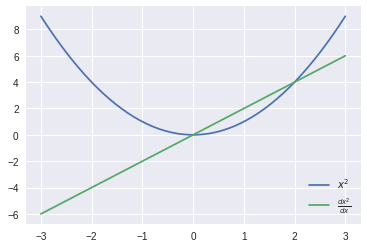

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(-3, 3)
x_squared, x_squared_der = s.run([scalar_squared, derivative[0]],
                                 {my_scalar:x})

plt.plot(x, x_squared,label="$x^2$")
plt.plot(x, x_squared_der, label=r"$\frac{dx^2}{dx}$")
plt.legend();

In [35]:
type(derivative[0])

tensorflow.python.framework.ops.Tensor

# Why that rocks

In [0]:
my_vector = tf.placeholder('float32', [None])
# Compute the gradient of the next weird function over my_scalar and my_vector
# Warning! Trying to understand the meaning of that function may result in permanent brain damage
weird_psychotic_function = tf.reduce_mean(
    (my_vector+my_scalar)**(1+tf.nn.moments(my_vector,[0])[1]) + 
    1./ tf.atan(my_scalar))/(my_scalar**2 + 1) + 0.01*tf.sin(
    2*my_scalar**1.5)*(tf.reduce_sum(my_vector)* my_scalar**2
                      )*tf.exp((my_scalar-4)**2)/(
    1+tf.exp((my_scalar-4)**2))*(1.-(tf.exp(-(my_scalar-4)**2)
                                    )/(1+tf.exp(-(my_scalar-4)**2)))**2

der_by_scalar = tf.gradients(weird_psychotic_function, my_scalar)
der_by_vector = tf.gradients(weird_psychotic_function, my_vector)

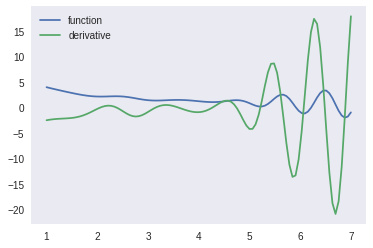

In [37]:
# Plotting the derivative
scalar_space = np.linspace(1, 7, 100)

y = [s.run(weird_psychotic_function, {my_scalar:x, my_vector:[1, 2, 3]})
     for x in scalar_space]

plt.plot(scalar_space, y, label='function')

y_der_by_scalar = [s.run(der_by_scalar,
                         {my_scalar:x, my_vector:[1, 2, 3]})
                   for x in scalar_space]

plt.plot(scalar_space, y_der_by_scalar, label='derivative')
plt.grid()
plt.legend();

# Almost done - optimizers

While you can perform gradient descent by hand with automatic gradients from above, tensorflow also has some optimization methods implemented for you. Recall momentum & rmsprop?

In [0]:
y_guess = tf.Variable(np.zeros(2, dtype='float32'))
y_true = tf.range(1, 3, dtype='float32')

loss = tf.reduce_mean((y_guess - y_true + 0.5*tf.random_normal([2]))**2) 

step = tf.train.MomentumOptimizer(0.03, 0.5).minimize(loss, var_list=y_guess)

Let's draw a trajectory of a gradient descent in 2D

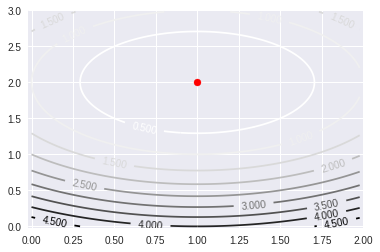

In [44]:
from matplotlib import animation, rc
import matplotlib_utils
from IPython.display import HTML, display_html

# nice figure settings
fig, ax = plt.subplots()
y_true_value = s.run(y_true)
level_x = np.arange(0, 2, 0.02)
level_y = np.arange(0, 3, 0.02)
X, Y = np.meshgrid(level_x, level_y)
Z = (X - y_true_value[0])**2 + (Y - y_true_value[1])**2
ax.set_xlim(-0.02, 2)
ax.set_ylim(-0.02, 3)
s.run(tf.global_variables_initializer())
ax.scatter(*s.run(y_true), c='red')
contour = ax.contour(X, Y, Z, 10)
ax.clabel(contour, inline=1, fontsize=10)
line, = ax.plot([], [], lw=2)

# start animation with empty trajectory
def init():
    line.set_data([], [])
    return (line,)

trajectory = [s.run(y_guess)]

# one animation step (make one GD step)
def animate(i):
    s.run(step)
    trajectory.append(s.run(y_guess))
    line.set_data(*zip(*trajectory))
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

In [45]:
try:
    display_html(HTML(anim.to_html5_video()))
except (RuntimeError, KeyError):
    # In case the build-in renderers are unaviable, fall back to
    # a custom one, that doesn't require external libraries
    anim.save(None, writer=matplotlib_utils.SimpleMovieWriter(0.001))

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAornLb4wfCS8%2BIk/wgs/ij4cl8W20Hn3PhePW7dtRii2q29rYP5qrtdGyVxhlPcU/Q/ix8LPE3jXU/ht4b%2BJXh/UPEeioH1nQLHWYJb2wU4wZoFcyRA7l5YD7w9aAOgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPlvx7dXd3%2B2N4I1jR/hX43s7bwr4z1KXxBpo8CyNopjn0a8iXxJBfWltm5vJHuLeyMLTylY5pi1ujRGdM39nnwR46svjj4P8LX3w81/T7/wV4m%2BIl/4r1%2B%2B0OeCyu7bVNXkntBDdugiuzciW3uSkTuY/sxWURuqqfraigCrrWpHSNMk1EQ%2BZ5e35N2M5YDr%2BNY154/8Askoi/sndmJHz5%2BPvIGx933xV/wAZ/wDItXP/AAD/ANDWuN1j/j7T/r1g/wDRSVvShGS1JbaN7/hZP/UF/wDJn/7Gmy/E6OCMyy6QFVRkk3PT/wAdrkZrySG9SB4cRuMCTP8AF6YqheRS27zRtJCzTPhN7EyFWPAHPQHt6CrdOmugJs7OT4uF3CWOgiTClnDXJUgAjIAKdee9WoficlxCs8WjZV1BU/aOx/4DXEx2F1PdtduDA4UbWGGDNggn6EbfyFXbaBbWBbdCSFGMnvQqUeqBs6OL4j629x9om8NRR2Zd40Y3mXdl2nPC8DDDrVj/AIWT/wBQX/yZ/wDsawZv%2BQLb/wDX1N/6DFVWmqUBXZ1H/Cyf%2BoL/AOTP/wBjR/wsn/qC/wDkz/8AY1y9Kqs5wqkn2FP2VPsF2dP/AMLJ/wCoL/5M/wD2NSp4/wB9lJef2T/q5UTb5/XcGOfu/wCz%2BtcsLZxzIyp/vGrEQRdKmwd6faIt3Y52yYx7df0qHCl0Q7s3P%2BFk/wDUF/8AJn/7GlHxHJ6aIT9Lj/7Gua85F/1cCj3PNIbmcjHmED0HFP2cX0/ELnUD4gTkZ/sEge9zj/2Wl/4WCR9/S0H/AG9f4LXKEk9ST9aSj2KDmOui8ei4cxxaaCwRm/13ZVLH%2BH0FQH4iyBwRp6svddxBP4//AFqwtH/4%2B3/69Z//AEU9VaFRhcOZnUf8LJ/6gv8A5M//AGNH/Cyf%2BoL/AOTP/wBjXL0VXsqfYV2dR/wsn/qC/wDkz/8AY1LY%2BP8A7bew2f8AZO3zZVTd5%2BcZOM/drkqtaH/yGrP/AK%2Bo/wD0IUnShbYLs3v%2BFk/9QX/yZ/8AsaP%2BFk/9QX/yZ/8Asa5ein7Kn2C7Oo/4WT/1Bf8AyZ/%2Bxo/4WT/1Bf8AyZ/%2Bxrl6KPZU%2BwXZ08fxEf8A5a2Kn6Ej/GrFx48FtO9tJpqh43KuDOeoOD/DXIVa1z/kNXn/AF9Sf%2BhGp9jC4%2BZnQP8AEXYcf2Qrf7tz/wDY0xviNJINsWkqrHoWmyPywK5ilRyhyAD9RT9lGwrs6hPiNuHzaP7f8fH/ANjSn4iMBn%2Bxfw%2B0/wD2NcusgAwV75HNOWRd27PJx%2BFS6aT2Hc6m4%2BIIgjiYaUGMkZZl%2B0fdO5hj7vtn8ai/4WT/ANQX/wAmf/sa5%2B9V0t7UNjBgJUjuPMf%2BoNQrDI670Qke1NU6drsLs6b/AIWT/wBQX/yZ/wDsaP8AhZP/AFBf/Jn/AOxrlyCOCKKr2VPsK7Oo/wCFk/8AUF/8mf8A7Gq9p8SNbDM%2Bo%2BGYhC0jiGeK84OMHaQVznDDnpXP1am/5Atv/wBfU3/oMVJ0oaBdm8fiTgZ/sb/yZ/8Asaq23xaDWJvrzQ1iUE8i6JGM8fwVzl3btdQNCs7xkj7yY/rVa6t5UtY7d4GkVCDm3O0gjG04J9fr2pOlBdB3Z2kPxPiuEEsGlK6nut1n/wBlp3/Cyf8AqC/%2BTP8A9jXn8l1NGhmurgrLHIF2o2OgDOxA68A%2B3NXrO7upJzDdRopMQcKucrnsfehQpvoGp6D4d8W/29etZ/2f5W2Ivu83dnBAx0HrWzXG/Dz/AJDUv/Xq3/oS12VY1YqM7Ia1QUUUVmMKKKKACiiigAooooAKKKKAMvxn/wAi1c/8A/8AQ1rg7zV7O/1VrW0Lv5NtCskgQ7QwjUFc%2Bua7zxn/AMi1c/8AAP8A0Na43VwBdpgY/wBFg/8ARSV00diWZ97afbIhEZmTDA7kAzx6Z6U%2BKFIlCrk4/iY5P5mn0VtZXJCjr0op%2BM4eNeR1FDdgLMij%2BxoFdsYupf1WP/Cq7IANpA%2B7kEetTSkLpkTBchriTk/7qcfrVYuxJwcZ7ZqEpMegA4IJGcHoac1xKw2hto9FGKZRVtJ7iDr1q1D/AMgW4/6%2Bof8A0GWqtWof%2BQLcf9fUP/oMtDAq0UU%2BC2ubp/LtoHkb%2B6ikn9KYDKK0V8M6ig338kFqp73EwB/IZNH2Hw7bf8fOsyzEdVtoMfq1TzLoOxBo/wDx9v8A9es//op6q1s6bd6BHcstppErkW8p3z3HUCNiRhR3HH41X/4SHy/%2BPXRrGP0Pkbj%2BbE0ru%2BwGcAScAVKljey/6uzlb/djJq4fFWu4xHeCMekcSr/IVE/iDXJPvatcf8BlI/lT94NBq6JrL/d0m5P/AGwb/CrWj6HrMWrWs0ulzqq3KFmaIgABhzVJtV1N/v6jOfrM3%2BNWNFvbx9ZtFe7lINzGCDIefmFJ81g0GHQNcHXSLn/vyaY2j6un39LuR9YG/wAKjF/fDpey/wDfw09dX1ZPuancD6Tt/jT98NCN7W6j/wBZbSL/ALyEVHV1PEmvR/d1ac/7z5/nUn/CVaw3E8sUw9JbdD/Sj3g0M6rWuf8AIavP%2BvqT/wBCNT/27bS8XegWT%2BpjQof0NWNVm8Nyarcpd2d1E4uHDSQyhgx3HnBH6Uru%2BwGNRWj/AGVo1x/x5a%2Bik9Euoin6jIps3hrWI082K2E6f37dw4/TmnzRCzKFFK6PGxSRCpHUEYIpKoRa1D/j0sf%2BvU/%2BjZKqglTkHB9qtah/x6WP/Xqf/RslVaS2AkFw5GJQHH%2B0KMW8n3WKH0PIqOilyrpoO494ZEG4jI/vDkVPN/yBbf8A6%2Bpv/QYqrpI8ZyjkfSrUhEmlwvM%2B1TcShQq9DtTJ/HI/Kk3JbhoU6KfJC8Y3cFT0YdKZVJp7CI57S3uFdXjGZF2swHOPrSW1oltubezu5%2Bd3PJ9OlS0UWVwN74dnOtSnH/Lq3/oS12Vcb8PP%2BQ1L/wBerf8AoS12Vctb4y47BRRRWQwooooAKKKKACiiigDxj9oD4v8Axy%2BFfxN8KweG28IXGg%2BIPE2jaLY%2BG5bO6n1vWHuLorqNxDIsscVrHZWe68OYp/MS3